# Imports

In [1]:
from pathlib import Path

import numpy as np
import matplotlib
from scipy.spatial.transform import Rotation

from multiview_mapping_toolkit.config import MATPLOTLIB_PALLETE, VIS_FOLDER
from multiview_mapping_toolkit.utils.example_data import (
    create_non_overlapping_points,
    create_scene_mesh,
)
from multiview_mapping_toolkit.cameras.cameras import PhotogrammetryCameraSet
from multiview_mapping_toolkit.meshes.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.segmentation.derived_segmentors import LookUpSegmentor
from multiview_mapping_toolkit.segmentation.segmentor import (
    SegmentorPhotogrammetryCameraSet,
)

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-22 20:43:15:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpawrildyi


# Config options

In [2]:
# Where to save content
CONCEPT_FIGURE_ROOT = Path(VIS_FOLDER, "concept_figure_content")
IMAGE_FOLDER = Path(CONCEPT_FIGURE_ROOT, "realistic_images")
FIGURES_SAVE_FOLDER = Path(CONCEPT_FIGURE_ROOT, "figures")
LABEL_IMAGES_FOLDER = Path(CONCEPT_FIGURE_ROOT, "labeled_images")

# Save vis or show them in the notebook
SAVE_VIS = True

# Number of map elements
N_BOXES = 5
N_CYLINDERS = 5
N_CONES = 5
# Random seed for object locations
MAP_RANDOM_SEED = 42
# Discritization of the ground plane
GROUND_RESOLUTION = 200

# Range of hues for each object
HUE_RANGE_DICT = {"cone": 0.1, "cylinder": 0.2, "cube": 0.1}
# Only used for realist
REALISTIC_COLOR_DICT = {
    "cone": MATPLOTLIB_PALLETE[0],
    "cylinder": MATPLOTLIB_PALLETE[2],
    "cube": MATPLOTLIB_PALLETE[1],
}

# Camera set params
CAM_HEIGHT = 10
CAM_DIST_FROM_CENTER = 10
CAM_PITCH = 225

CAM_INTRINSICS = {
    0: {"f": 4000, "cx": 0, "cy": 0, "image_width": 3000, "image_height": 2200}
}

# Create the example data

In [3]:
points = create_non_overlapping_points(
    n_points=(N_BOXES + N_CYLINDERS + N_CONES), random_seed=MAP_RANDOM_SEED
)

mesh, labels_gdf = create_scene_mesh(
    box_centers=points[:N_BOXES],
    cylinder_centers=points[N_BOXES : (N_BOXES + N_CYLINDERS)],
    cone_centers=points[(N_BOXES + N_CYLINDERS) : (N_BOXES + N_CYLINDERS + N_CONES)],
    add_ground=True,
    ground_resolution=GROUND_RESOLUTION,
)

# Define the colors for the "realistic" views

In [4]:
def make_color_gradient(color, number, hue_range=None):
    if hue_range is None:
        hue_range = 1 / (number * 2)

    hsv_color = matplotlib.colors.rgb_to_hsv(color)
    hue_start = hsv_color[0] - hue_range / 2
    hue_end = hsv_color[0] + hue_range / 2
    hues = np.linspace(hue_start, hue_end, number) % 1.0
    shifted_HSVs = [np.concatenate(([hue], hsv_color[1:]), axis=0) for hue in hues]
    rgb_values = [
        matplotlib.colors.hsv_to_rgb(shifted_hue) for shifted_hue in shifted_HSVs
    ]
    rgb_values = np.vstack(rgb_values)

    rgb_values = rgb_values / 255.0

    return rgb_values

colors_per_face = np.full((mesh.n_cells, 3), fill_value=0.5)
IDs_per_face = np.full((mesh.n_cells, 1), fill_value=np.nan)

for i, (name, group) in enumerate(labels_gdf.groupby("name")):
    num = len(group)
    gradient = make_color_gradient(
        REALISTIC_COLOR_DICT[name], num, hue_range=HUE_RANGE_DICT[name]
    )
    # Indices into the original dataset
    IDs = group.index.to_numpy()
    # TODO rename
    for ID, color in zip(IDs, gradient):
        matching = mesh["ID"] == ID
        colors_per_face[matching, :] = color
        IDs_per_face[matching, :] = i

# Show the 2D map

<Axes: >

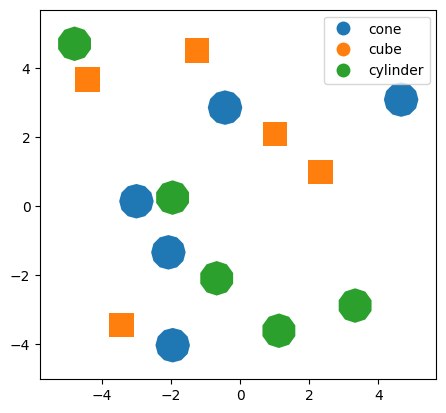

In [5]:
labels_gdf.plot("name", legend=True, cmap="tab10", vmin=0, vmax=9)

# Create a set of virtual cameras

In [6]:
# Create translations
t_vecs = (
    (0, 0, CAM_HEIGHT),
    (0, CAM_DIST_FROM_CENTER, CAM_HEIGHT),
    (CAM_DIST_FROM_CENTER, 0, CAM_HEIGHT),
    (-CAM_DIST_FROM_CENTER, 0, CAM_HEIGHT),
    (0, -CAM_DIST_FROM_CENTER, CAM_HEIGHT),
)
# Create rotations in roll, pitch, yaw convention
r_vecs = (
    (180, 180, 0),  # nadir
    (180, CAM_PITCH, 0),  # oblique
    (90, CAM_PITCH, 0),  # oblique
    (270, CAM_PITCH, 0),  # oblique
    (0, CAM_PITCH, 0),  # oblique
)

# Create 4x4 transforms
cam_to_world_transforms = []
for r_vec, t_vec in zip(r_vecs, t_vecs):
    r_mat = Rotation.from_euler("ZXY", r_vec, degrees=True).as_matrix()
    transform = np.eye(4)
    transform[:3, :3] = r_mat
    transform[:3, 3] = t_vec
    cam_to_world_transforms.append(transform)

IMAGE_FOLDER.mkdir(exist_ok=True, parents=True)
# Note that these files do not exist yet, but will be later created
image_filenames = [Path(IMAGE_FOLDER, f"img_{i:03d}.png") for i in range(5)]

camera_set = PhotogrammetryCameraSet(
    cam_to_world_transforms=cam_to_world_transforms,
    intrinsic_params_per_sensor_type=CAM_INTRINSICS,
    image_folder=IMAGE_FOLDER,
    image_filenames=image_filenames,
)

# Create a colored mesh with a "realistic" textuer

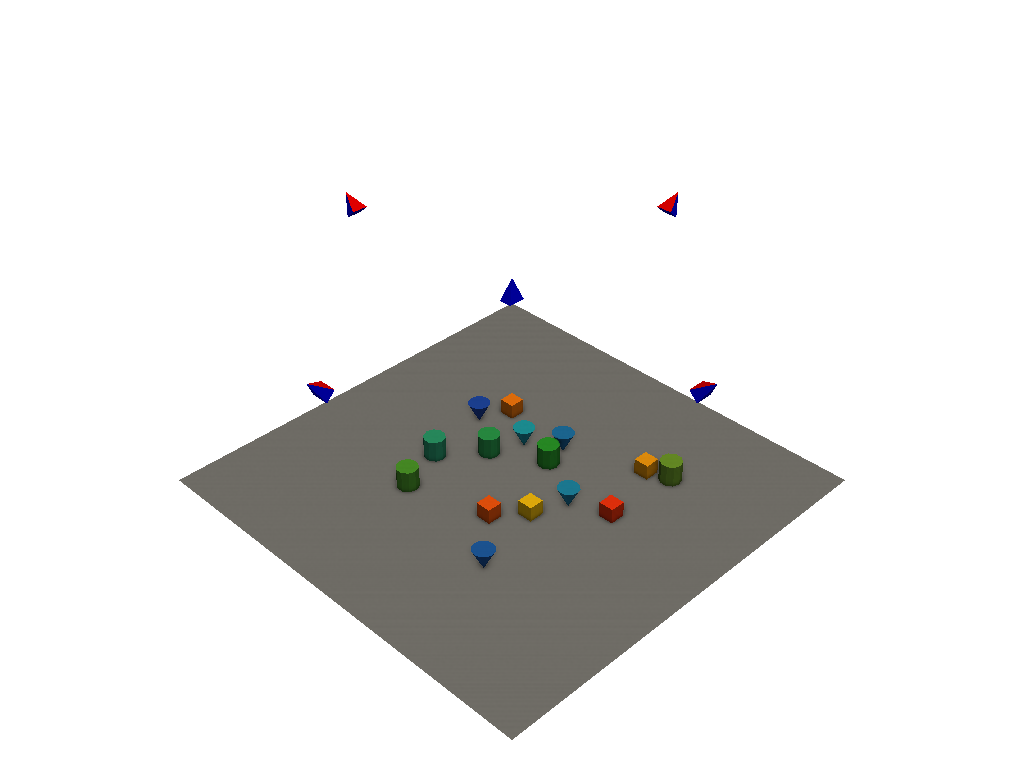

In [7]:
realistic_mesh = TexturedPhotogrammetryMesh(mesh, texture=colors_per_face)
realistic_mesh.vis(
    force_xvfb=True,
    camera_set=camera_set,
    screenshot_filename=Path(FIGURES_SAVE_FOLDER, "realistic_scene.png"),
)

# Create a mesh textured with the labels

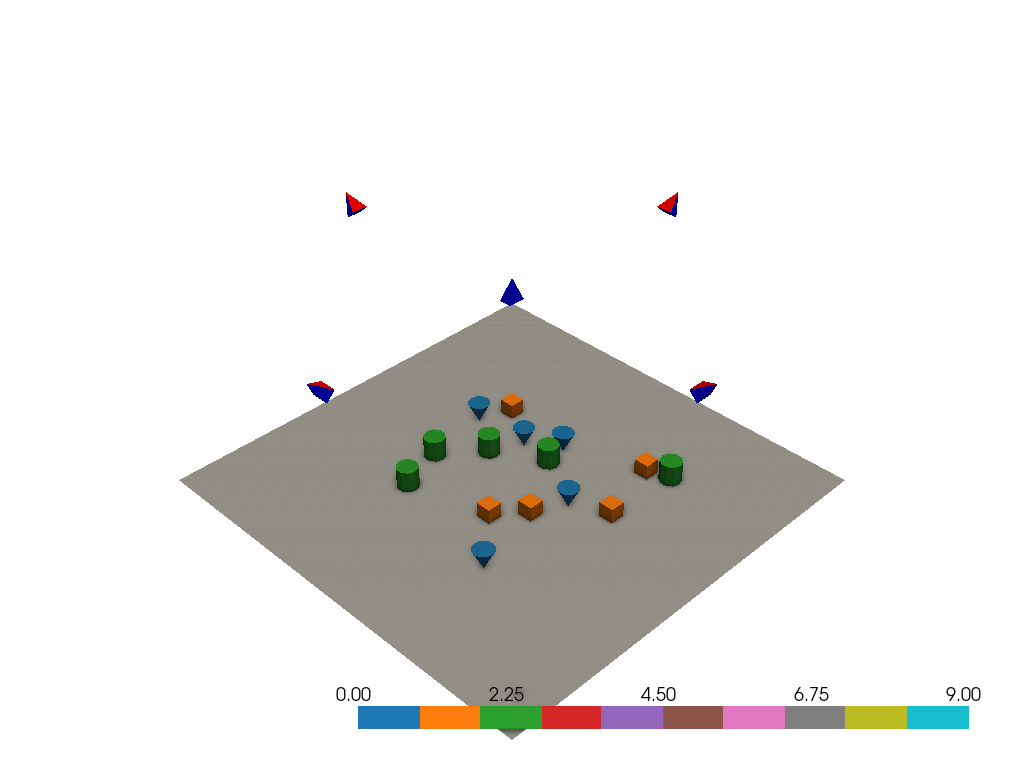

In [8]:
labeled_mesh = TexturedPhotogrammetryMesh(
    mesh, texture=IDs_per_face, texture_column_name="name"
)
labeled_mesh.vis(
    force_xvfb=True,
    camera_set=camera_set,
    screenshot_filename=Path(FIGURES_SAVE_FOLDER, "labeled_scene.png"),
)

# Render from the camera viewpoints

In [9]:
import matplotlib.pyplot as plt
from imageio import imwrite

FIGURES_SAVE_FOLDER.mkdir(exist_ok=True, parents=True)
LABEL_IMAGES_FOLDER.mkdir(exist_ok=True, parents=True)

for i in range(5):
    # Do the three types of rendering
    label_render = labeled_mesh.render_pytorch3d(
        camera_set,
        i,
        shade_by_indexing=True,
    )
    flat_texture_render = realistic_mesh.render_pytorch3d(
        camera_set, i, shade_by_indexing=True
    )
    realistic_render = realistic_mesh.render_pyvista(camera_set, i, enable_ssao=True)

    # Save out an integer label image
    label_render_for_saving = label_render.copy()
    label_render_for_saving[np.logical_not(np.isfinite(label_render_for_saving))] = 255
    label_render_for_saving = label_render_for_saving.astype(np.uint8)
    imwrite(Path(LABEL_IMAGES_FOLDER, f"img_{i:03d}.png"), label_render_for_saving)
    # Save out the rendered "realistic imager"
    image_path = camera_set.get_image_filename(i, absolute=True)
    imwrite(image_path, realistic_render)

    # Save or vis the figures
    plt.axis("off")
    plt.tight_layout()
    plt.imshow(flat_texture_render)

    if SAVE_VIS:
        plt.savefig(Path(FIGURES_SAVE_FOLDER, f"texture_render_flat_{i:03d}.png"))
        plt.close()
    else:
        plt.show()

    plt.axis("off")
    plt.tight_layout()
    plt.imshow(
        label_render,
        cmap="tab10",
        vmin=0,
        vmax=9,
        interpolation="none",
    )
    if SAVE_VIS:
        plt.savefig(Path(FIGURES_SAVE_FOLDER, f"class_render_flat{i:03d}.png"))
        plt.close()
    else:
        plt.show()

    plt.axis("off")
    plt.tight_layout()
    plt.imshow(realistic_render)
    if SAVE_VIS:
        plt.savefig(Path(FIGURES_SAVE_FOLDER, f"texture_render_realistic_{i:03d}.png"))
        plt.close()
    else:
        plt.show()

# Create a segmentor that looks up labeled images

In [10]:
segmentor = LookUpSegmentor(IMAGE_FOLDER, LABEL_IMAGES_FOLDER, num_classes=3)
segmentor_camera_set = SegmentorPhotogrammetryCameraSet(camera_set, segmentor)
aggregation_mesh = TexturedPhotogrammetryMesh(mesh=mesh)

# Show which faces were projected onto at all

Aggregating information from different viewpoints:   0%|          | 0/1 [00:00<?, ?it/s]

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


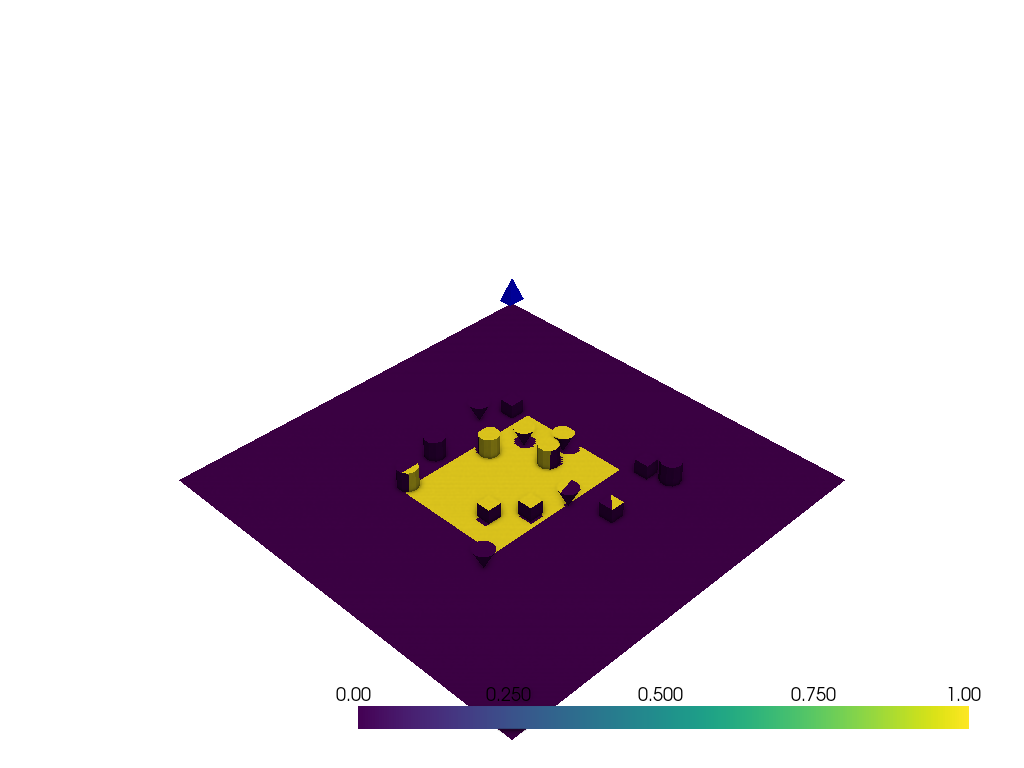

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


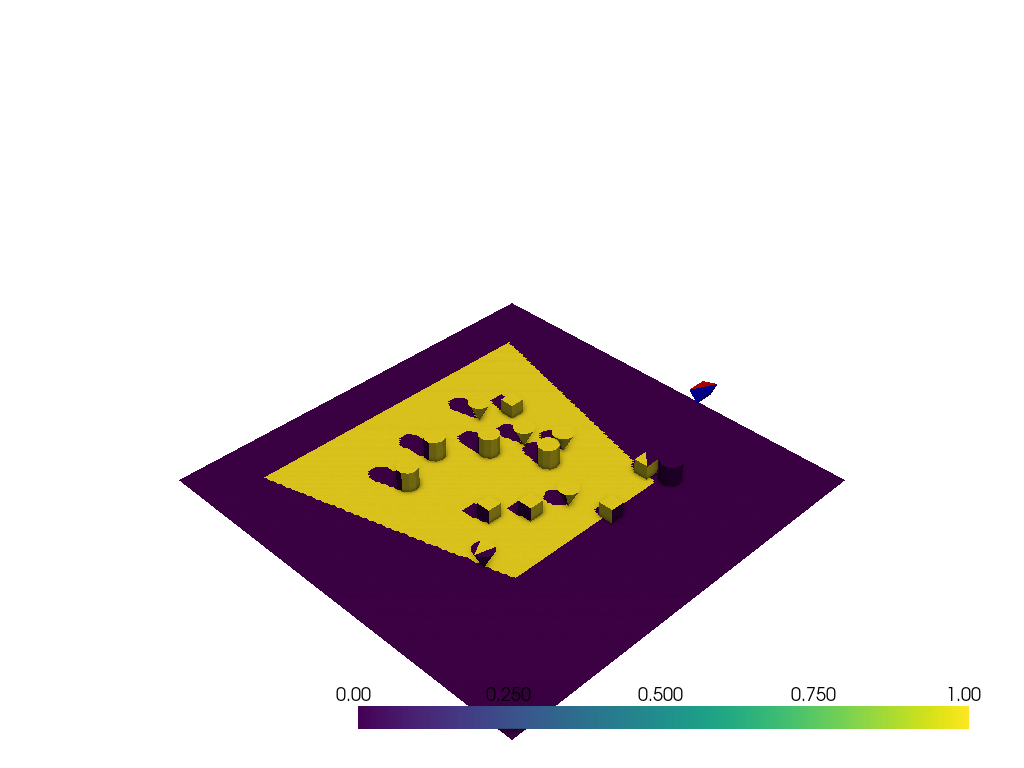

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


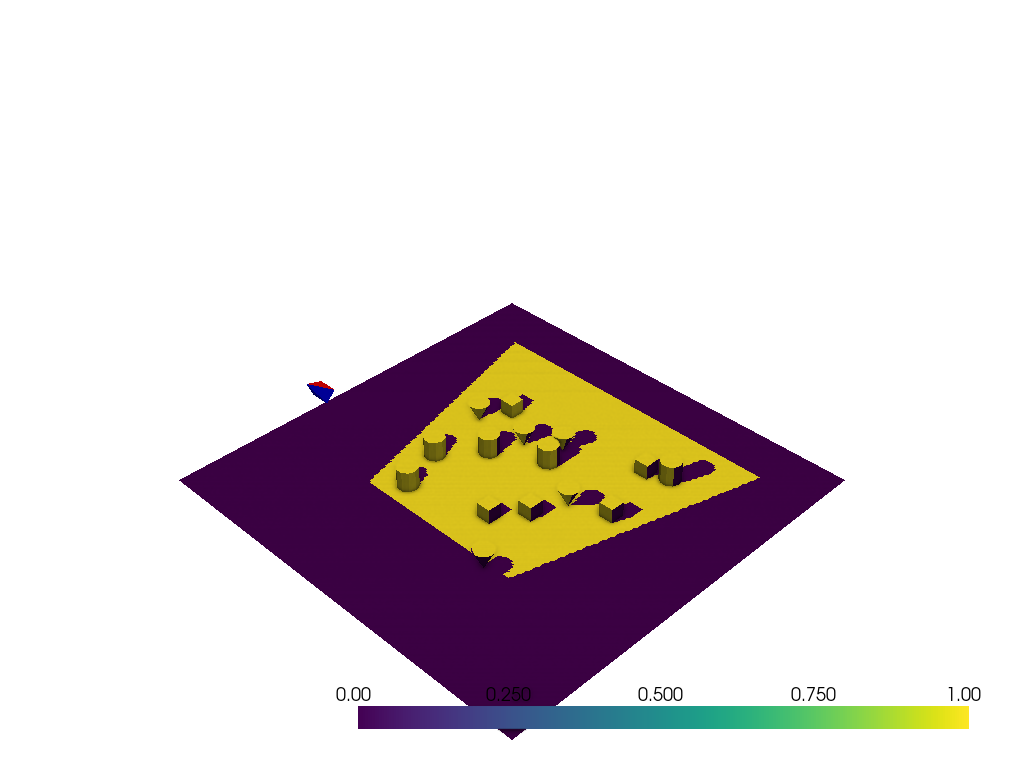

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


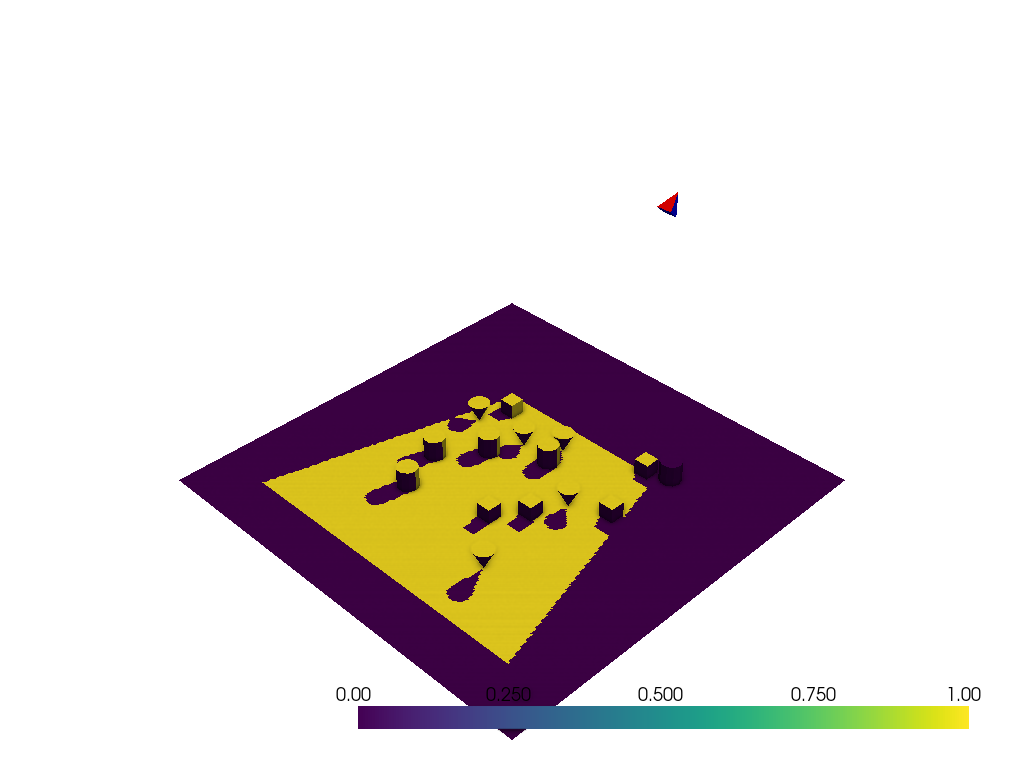

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


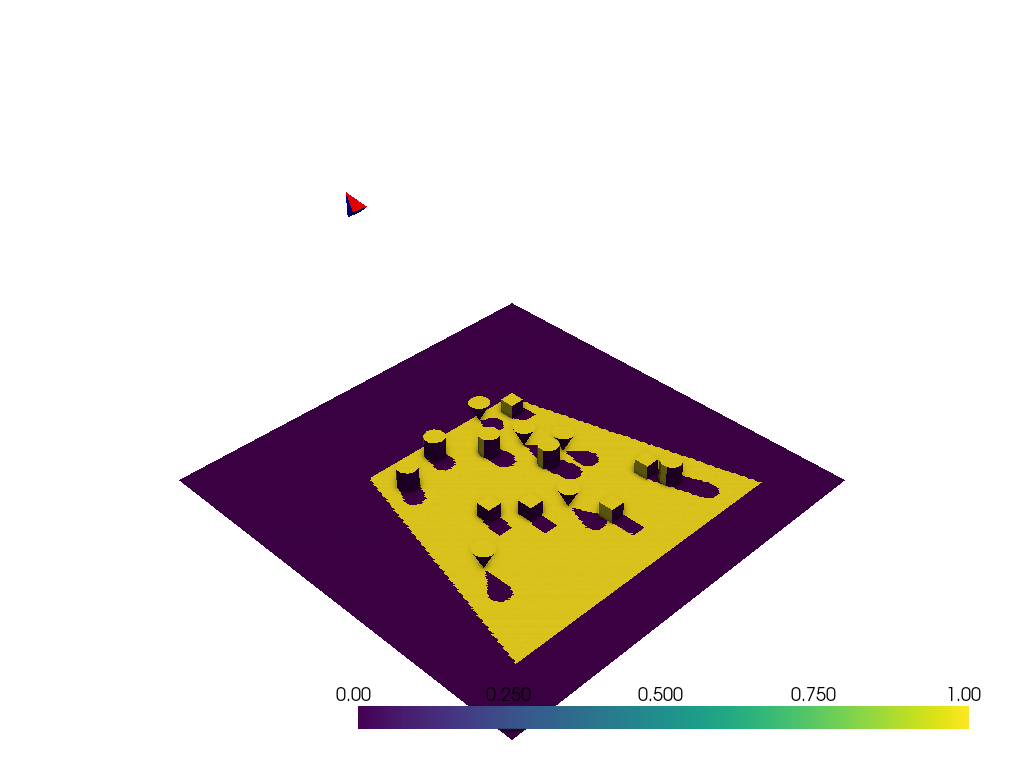

In [11]:
for i in range(5):
    sub_camera_set = segmentor_camera_set.get_subset_cameras([i])
    (
        normalized_face_texture,
        face_texture,
        counts,
    ) = aggregation_mesh.aggregate_viewpoints_pytorch3d(sub_camera_set)
    aggregation_mesh.vis(
        vis_scalars=counts,
        camera_set=sub_camera_set,
        screenshot_filename=Path(FIGURES_SAVE_FOLDER, f"view_shadows_scene_{i:03d}.png"),
    )

Aggregating information from different viewpoints:   0%|          | 0/1 [00:00<?, ?it/s]

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


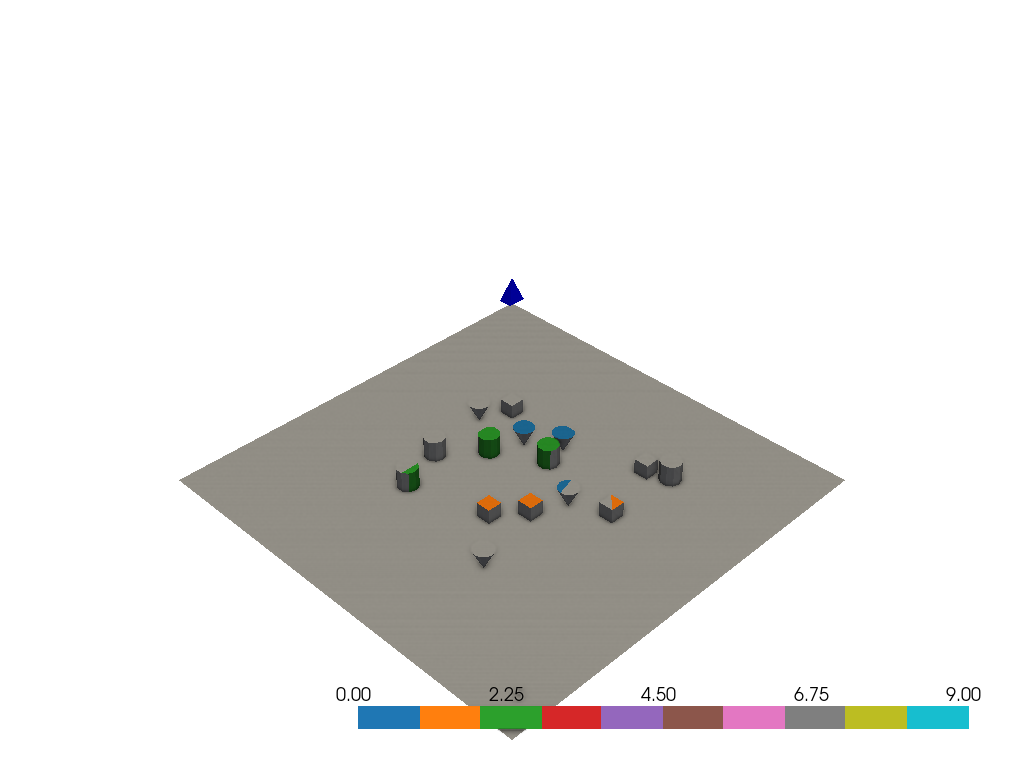

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


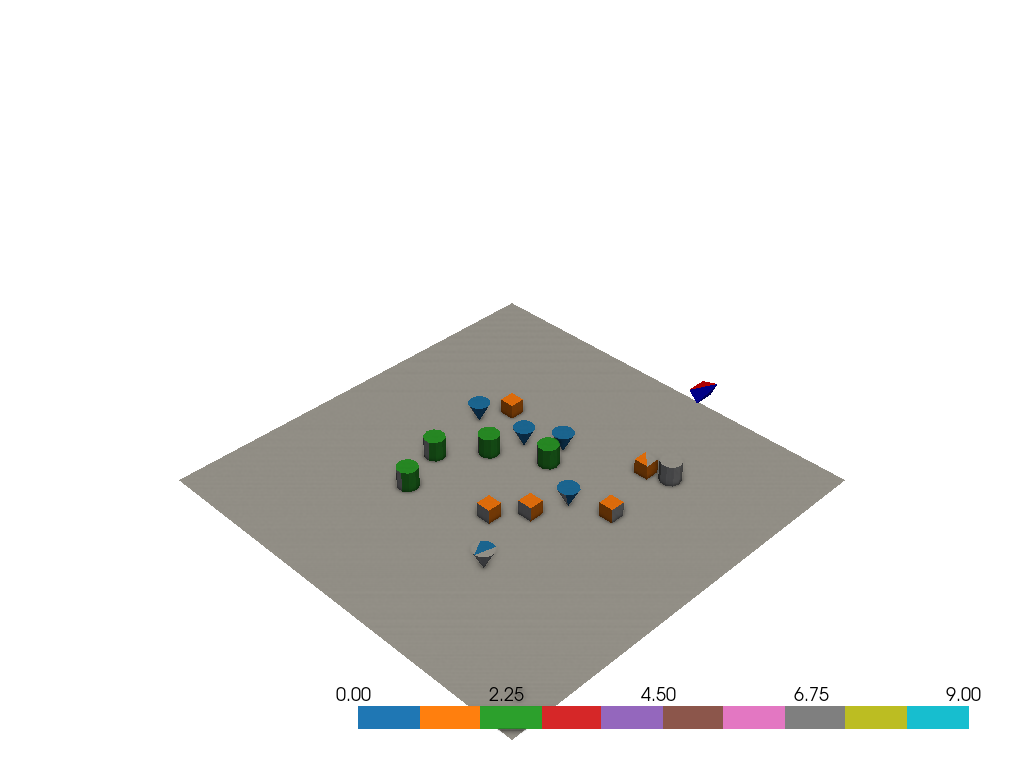

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


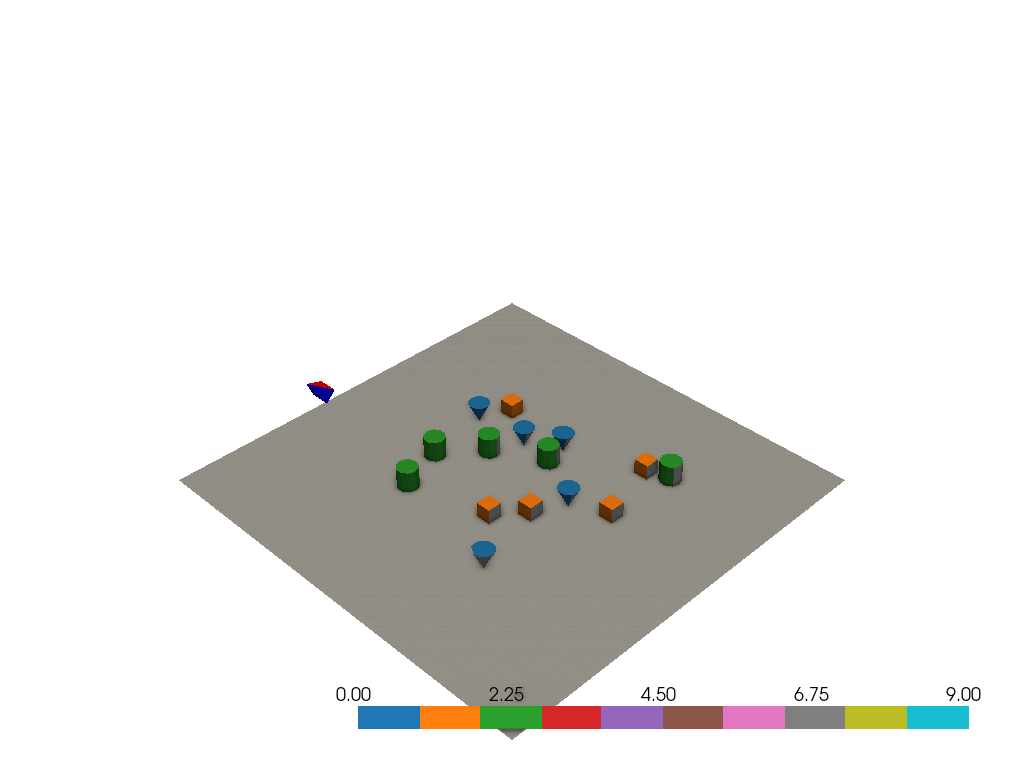

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


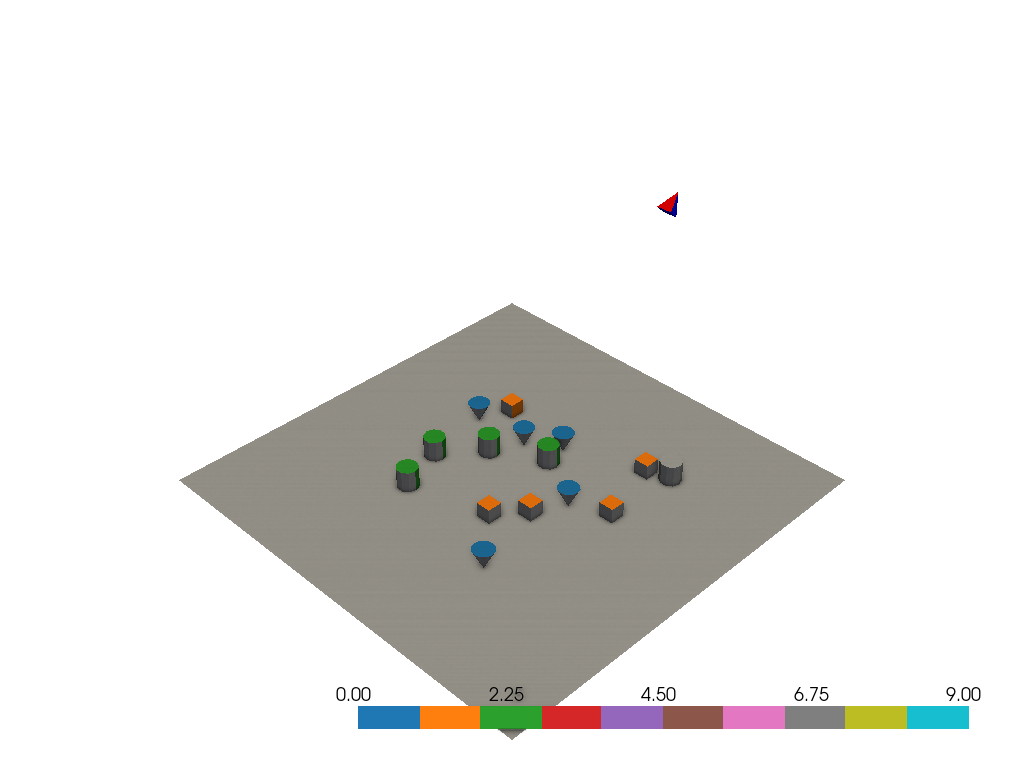

Aggregating information from different viewpoints: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


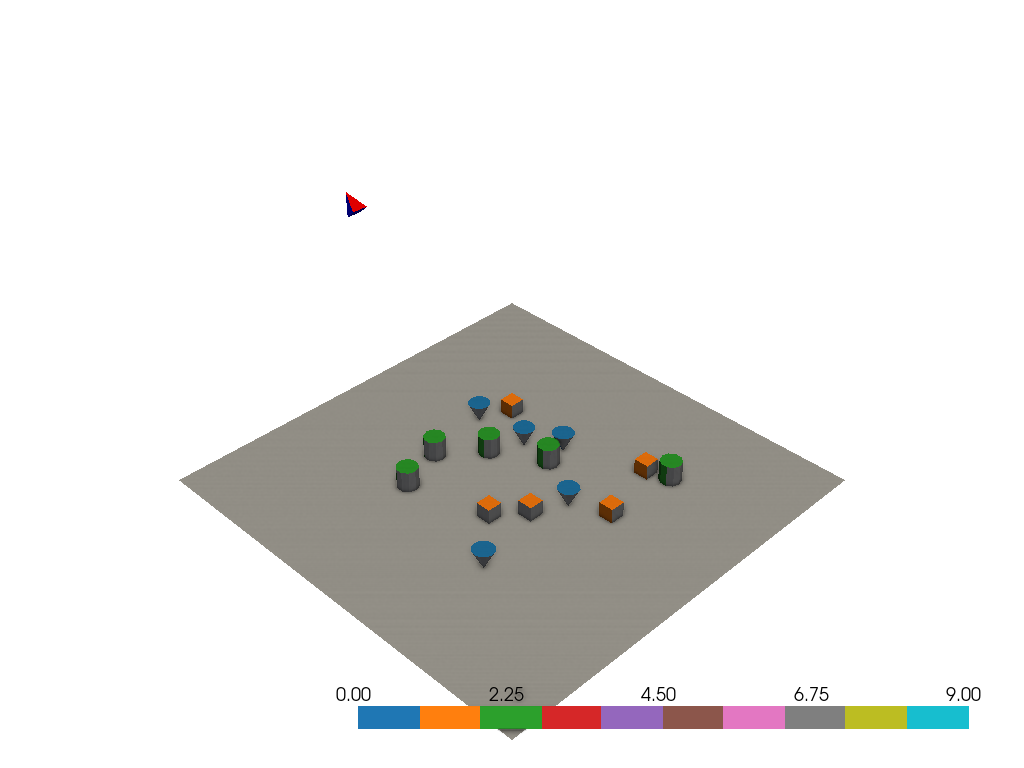

In [12]:
for i in range(5):
    sub_camera_set = segmentor_camera_set.get_subset_cameras([i])
    (
        normalized_face_texture,
        face_texture,
        counts,
    ) = aggregation_mesh.aggregate_viewpoints_pytorch3d(sub_camera_set)
    max_class = np.argmax(face_texture, axis=1).astype(float)
    zeros_mask = np.sum(face_texture, axis=1) == 0
    max_class[zeros_mask] = np.nan
    aggregation_mesh.vis(
        vis_scalars=max_class,
        camera_set=sub_camera_set,
        force_xvfb=True,
        mesh_kwargs={"cmap": "tab10", "clim": (0, 9)},
        screenshot_filename=Path(FIGURES_SAVE_FOLDER, f"aggregated_predicted_scene_{i:03d}.png"),  
    )

# Show aggregated viewpoint

Aggregating information from different viewpoints: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


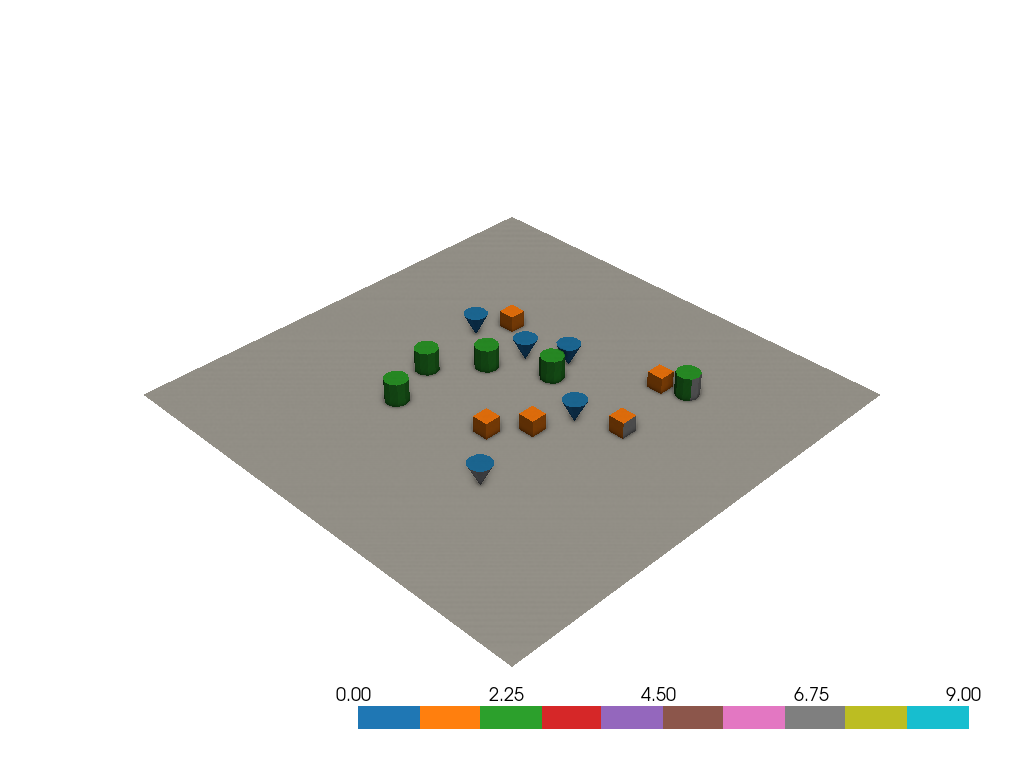

In [13]:
(
    normalized_face_texture,
    face_texture,
    counts,
) = aggregation_mesh.aggregate_viewpoints_pytorch3d(segmentor_camera_set)
max_class = np.argmax(face_texture, axis=1).astype(float)
zeros_mask = np.sum(face_texture, axis=1) == 0
max_class[zeros_mask] = np.nan
aggregation_mesh.vis(
    vis_scalars=max_class,
    force_xvfb=True,
    mesh_kwargs={"cmap": "tab10", "clim": (0, 9)},
    screenshot_filename=Path(FIGURES_SAVE_FOLDER, "aggregated_predicted_scene.png"),
)